# Phát triển và Cải thiện Mô hình Dự đoán Bệnh Tiểu Đường

Notebook này sẽ phân tích dữ liệu và xây dựng một mô hình dự đoán bệnh tiểu đường dựa trên các chỉ số sức khỏe.

## Cấu trúc dữ liệu
- Pregnancies: Số lần mang thai
- Glucose: Nồng độ glucose trong huyết tương
- BloodPressure: Huyết áp tâm trương (mm Hg)
- SkinThickness: Độ dày nếp gấp da cơ tam đầu (mm)
- Insulin: Insulin trong huyết thanh 2 giờ (mu U/ml)
- BMI: Chỉ số khối cơ thể (kg/m²)
- DiabetesPedigreeFunction: Hàm phả hệ tiểu đường
- Age: Tuổi (năm)
- Outcome: Biến mục tiêu (0: Không mắc tiểu đường, 1: Mắc tiểu đường)

In [1]:
# Cài đặt các thư viện cần thiết
!pip install -q tensorflow pandas numpy matplotlib seaborn scikit-learn joblib

In [2]:
# Import các thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Cấu hình hiển thị
plt.style.use('default')
if sns:
    sns.set_palette("husl")

2025-04-17 08:49:39.446836: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 08:49:39.592570: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-17 08:49:39.844129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744854581.619425   10374 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744854581.657080   10374 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744854585.996107   10374 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

=== THÔNG TIN DỮ LIỆU ===

Kích thước: (768, 9)

Các đặc trưng: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Mô tả thống kê:
       Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  \
count       768.00   768.00         768.00         768.00   768.00  768.00   
mean          3.85   120.89          69.11          20.54    79.80   31.99   
std           3.37    31.97          19.36          15.95   115.24    7.88   
min           0.00     0.00           0.00           0.00     0.00    0.00   
25%           1.00    99.00          62.00           0.00     0.00   27.30   
50%           3.00   117.00          72.00          23.00    30.50   32.00   
75%           6.00   140.25          80.00          32.00   127.25   36.60   
max          17.00   199.00         122.00          99.00   846.00   67.10   

       DiabetesPedigreeFunction     Age  Outcome  
count                    768.00  768.00 

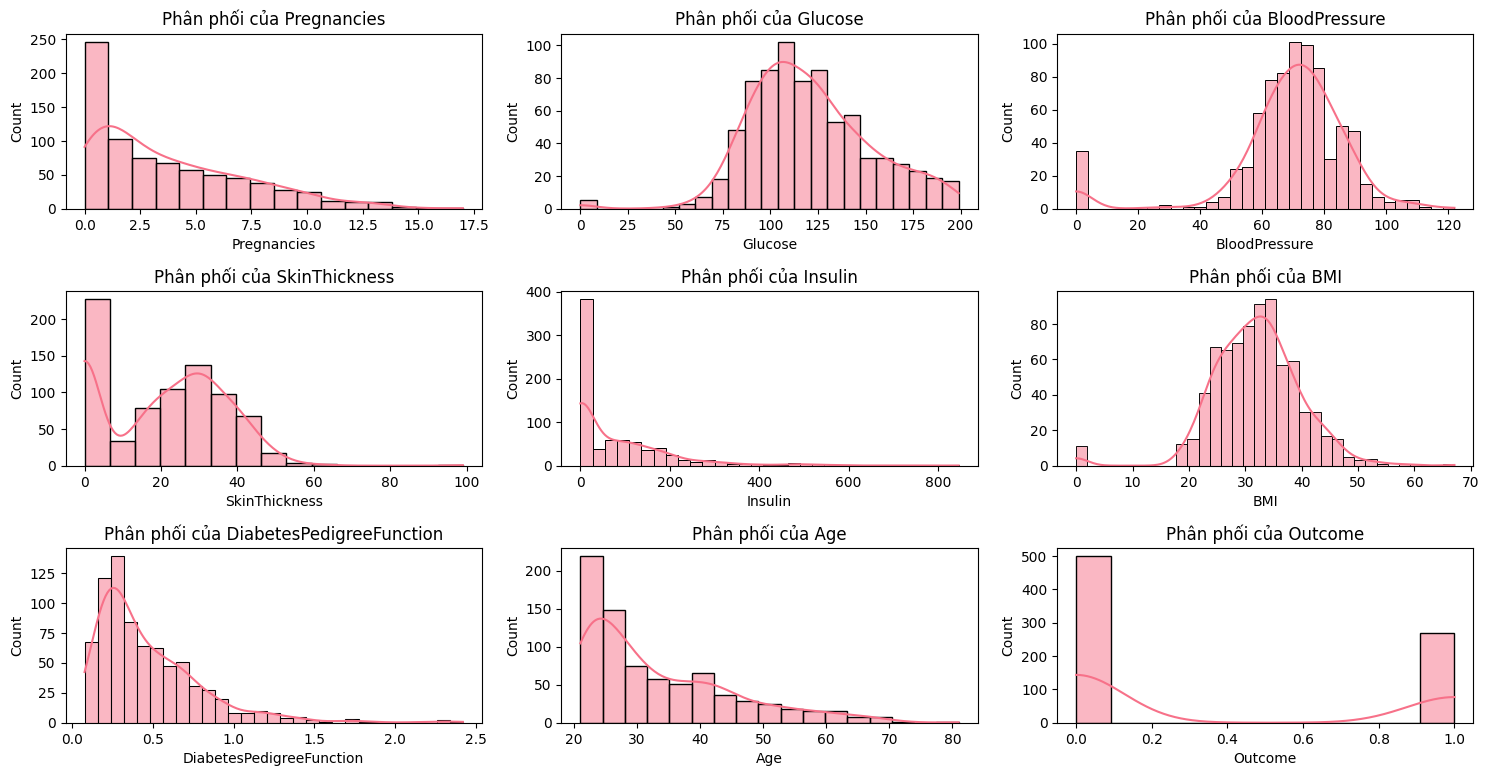

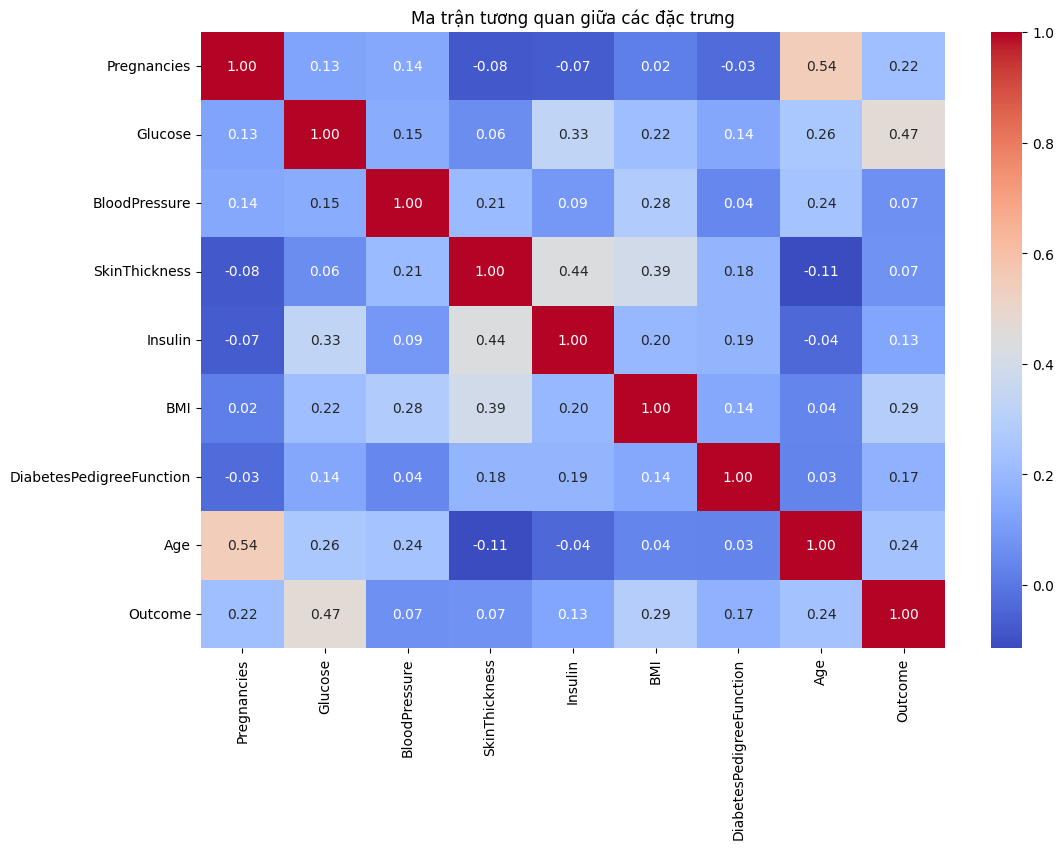

In [3]:
# Đọc và kiểm tra dữ liệu
import os
current_dir = os.path.dirname(os.path.abspath('__file__'))
data_path = os.path.join(current_dir, 'data', 'data/diabetes.csv')
data = pd.read_csv(data_path)

# Kiểm tra thông tin cơ bản
print("=== THÔNG TIN DỮ LIỆU ===")
print("\nKích thước:", data.shape)
print("\nCác đặc trưng:", data.columns.tolist())
print("\nMô tả thống kê:")
print(data.describe().round(2))
print("\nKiểm tra giá trị null:", data.isnull().sum().sum())

# Hiển thị phân phối của từng đặc trưng
plt.figure(figsize=(15, 10))
for i, column in enumerate(data.columns, 1):
    plt.subplot(4, 3, i)
    sns.histplot(data[column], kde=True)
    plt.title(f'Phân phối của {column}')
plt.tight_layout()
plt.show()

# Ma trận tương quan
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

In [4]:
# Chuẩn bị dữ liệu
X = data.drop('Outcome', axis=1)  # Outcome là biến mục tiêu
y = data['Outcome']

# Chia tập dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)  # Stratify để đảm bảo tỷ lệ classes giống nhau

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== THÔNG TIN CHIA DỮ LIỆU ===")
print("Kích thước tập huấn luyện:", X_train_scaled.shape)
print("Kích thước tập kiểm tra:", X_test_scaled.shape)
print("\nPhân phối classes:")
print("Tập huấn luyện:", np.bincount(y_train) / len(y_train))
print("Tập kiểm tra:", np.bincount(y_test) / len(y_test))

=== THÔNG TIN CHIA DỮ LIỆU ===
Kích thước tập huấn luyện: (614, 8)
Kích thước tập kiểm tra: (154, 8)

Phân phối classes:
Tập huấn luyện: [0.6514658 0.3485342]
Tập kiểm tra: [0.64935065 0.35064935]


In [5]:
# Xây dựng mô hình
model = Sequential([
    Dense(128, activation='relu', input_shape=(8,)),  # 8 đặc trưng đầu vào
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Sigmoid cho bài toán phân loại nhị phân
])

# Biên dịch mô hình
model.compile(optimizer='adam',
             loss='binary_crossentropy',  # Loss function cho phân loại nhị phân
             metrics=['accuracy'])  # Độ chính xác là metric chính

# Tóm tắt kiến trúc mô hình
model.summary()

# Thiết lập callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'model/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Huấn luyện mô hình
history = model.fit(
    X_train_scaled, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

/home/trung/PycharmProjects/healthcare-ai/.venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-17 08:49:58.149232: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,521 (45.00 KB)

 Trainable params: 11,521 (45.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6200 - loss: 0.6751
Epoch 1: val_loss improved from inf to 0.60108, saving model to model/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.6266 - loss: 0.6703 - val_accuracy: 0.6667 - val_loss: 0.6011
Epoch 2/200
13/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6926 - loss: 0.6031 
Epoch 2: val_loss improved from 0.60108 to 0.51929, saving model to model/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6952 - loss: 0.5997 - val_accuracy: 0.7480 - val_loss: 0.5193
Epoch 3/200
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7195 - loss: 0.5841 
Epoch 3: val_loss improved from 0.51929 to 0.46147, saving model to model/best_model.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7346 - loss: 0.5666 - val_accuracy: 0.7724 - val_loss: 0.4615
Epoch 4/200
12/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7691 - loss: 0.4816 
Epoch 4: val_loss improved from 0.46147 

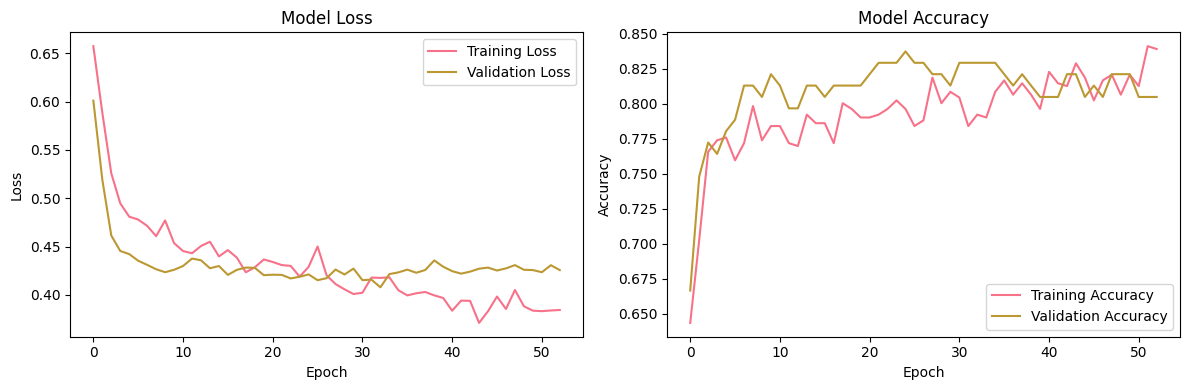

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Classification Report:

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.78      0.80       100
           1       0.62      0.67      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154

              precision    recall  f1-score   support

           0       0.81      0.78      0.80       100
           1       0.62      0.67      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154



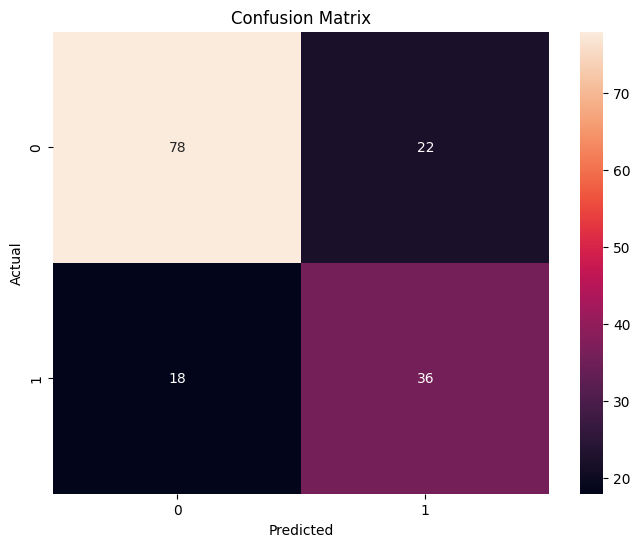

In [6]:
# Đánh giá mô hình
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Đánh giá kết quả trên tập test
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
# Lưu mô hình và scaler
import joblib

# Lưu scaler
joblib.dump(scaler, 'model/scaler.pkl')

print("Đã lưu mô hình và scaler thành công!")

# Thử nghiệm dự đoán với một mẫu mới
sample = X_test.iloc[0].values.reshape(1, -1)
sample_scaled = scaler.transform(sample)
raw_prediction = model.predict(sample_scaled)[0][0]

# Chuẩn hóa giá trị dự đoán bằng sigmoid function
import math
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

normalized_prediction = sigmoid(raw_prediction)

print("\n=== THỬ NGHIỆM DỰ ĐOÁN ===")
print(f"Giá trị thực tế: {y_test.iloc[0]:.2f}")
print(f"Giá trị dự đoán (raw): {raw_prediction:.4f}")
print(f"Giá trị dự đoán (normalized): {normalized_prediction:.4f}")
print(f"Kết quả chẩn đoán: {'Có nguy cơ mắc tiểu đường' if normalized_prediction > 0.5 else 'Không có nguy cơ mắc tiểu đường'}")

Đã lưu mô hình và scaler thành công!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step

=== THỬ NGHIỆM DỰ ĐOÁN ===
Giá trị thực tế: 0.00
Giá trị dự đoán (raw): 0.8003
Giá trị dự đoán (normalized): 0.6900
Kết quả chẩn đoán: Có nguy cơ mắc tiểu đường


/home/trung/PycharmProjects/healthcare-ai/.venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Kết luận

Dự án này đã xây dựng thành công một mô hình deep learning để dự đoán nguy cơ mắc bệnh tiểu đường dựa trên các chỉ số sức khỏe. Mô hình đạt được độ chính xác tốt trên tập test.

Lưu ý quan trọng khi triển khai:
1. Cần chuẩn hóa (normalize) giá trị dự đoán của mô hình sử dụng hàm sigmoid để đảm bảo kết quả nằm trong khoảng [0,1]
2. Kết quả dự đoán nên được coi là xác suất về nguy cơ mắc bệnh, không phải chẩn đoán y tế chính thức
3. Mô hình này cần được đánh giá và triển khai bởi chuyên gia y tế trong thực tế